# Chapter 4: Fine-Tuning Audio Classifiers

**Following the [Hugging Face Audio Course](https://huggingface.co/learn/audio-course/) with two classification tasks.**

The HF course fine-tunes DistilHuBERT on GTZAN for music genre classification. We do the same concept, then go further with environmental sounds.

**Same architecture, same pipeline, completely different tasks.** Swap the dataset and labels, everything else stays the same.

1. **Part A**: Music genre classification (GTZAN, 10 genres) with a pretrained checkpoint, tested on our Bach and jazz recordings
2. **Part B**: Environmental sound classification (ESC-50, 50 classes) trained from scratch on Colab
3. **Part C**: Test the ESC-50 model on our thunder and chimes field recordings

> **Why the split?** GTZAN has 30-second clips that eat too much RAM for Colab free tier during preprocessing. ESC-50 clips are 5 seconds, so training runs fine. We show the full training pipeline for ESC-50 and use an existing GTZAN checkpoint. The code is identical for both, only the data changes.

## Setup

In [5]:
!pip install -q transformers datasets==3.5.0 librosa torch matplotlib seaborn evaluate accelerate scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.


In [6]:
from google.colab import files
uploaded = files.upload()  # upload Bach.mp3, RainbowJazz.mp3, thunder.wav, chimes.wav

Saving Bach.mp3 to Bach.mp3
Saving RainbowJazz.mp3 to RainbowJazz.mp3
Saving thunder.wav to thunder.wav
Saving chimes.wav to chimes.wav


In [7]:
import torch
import librosa
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display

SR = 16000

# Music files for genre classification
bach, _ = librosa.load("Bach.mp3", sr=SR, mono=True)
jazz, _ = librosa.load("RainbowJazz.mp3", sr=SR, mono=True)

# Soundscape files for environmental classification
thunder, _ = librosa.load("thunder.wav", sr=SR, mono=True)
chimes, _ = librosa.load("chimes.wav", sr=SR, mono=True)

print("Music:")
print(f"  Bach:         {len(bach)/SR:.1f}s")
print(f"  RainbowJazz:  {len(jazz)/SR:.1f}s")
print(f"\nSoundscapes:")
print(f"  Thunder:      {len(thunder)/SR:.1f}s")
print(f"  Chimes:       {len(chimes)/SR:.1f}s")

Music:
  Bach:         1248.8s
  RainbowJazz:  362.3s

Soundscapes:
  Thunder:      27.3s
  Chimes:       53.5s


In [8]:
# Quick listen
for name, clip in [("Bach", bach), ("RainbowJazz", jazz), ("Thunder", thunder), ("Chimes", chimes)]:
    print(f"\n{name}:")
    display(Audio(clip[:SR*10], rate=SR))  # first 10 seconds


Bach:



RainbowJazz:



Thunder:



Chimes:


---

## Part A: Music Genre Classification (GTZAN)

GTZAN is 999 songs (one corrupted), each 30 seconds, across 10 genres: blues, classical, country, disco, hip-hop, jazz, metal, pop, reggae, rock.

The HF course fine-tunes DistilHuBERT on this dataset. The training pipeline is straightforward but GTZAN's 30-second clips require more RAM than Colab free provides for preprocessing. So we load a checkpoint that was already trained following the exact same procedure.

Here is what the training looks like. We run this same code for real in Part B with ESC-50.

```python
# GTZAN training code (for reference, not executed here)

from datasets import load_dataset, Audio
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification
from transformers import TrainingArguments, Trainer

gtzan = load_dataset("marsyas/gtzan", "all")
gtzan = gtzan["train"].train_test_split(seed=42, shuffle=True, test_size=0.1)

feature_extractor = AutoFeatureExtractor.from_pretrained(
    "ntu-spml/distilhubert", do_normalize=True, return_attention_mask=True
)
gtzan = gtzan.cast_column("audio", Audio(sampling_rate=16000))

model = AutoModelForAudioClassification.from_pretrained(
    "ntu-spml/distilhubert", num_labels=10,
    label2id=label2id, id2label=id2label,
)

# TrainingArguments: lr=5e-5, batch_size=8, 10 epochs, fp16
# Result: ~83% accuracy on 10 genres
```

### A1. Load the pretrained GTZAN model

In [9]:
from transformers import pipeline

pipe_gtzan = pipeline(
    "audio-classification",
    model="sanchit-gandhi/distilhubert-finetuned-gtzan",
    device=0 if torch.cuda.is_available() else -1,
)

print(f"Model: {pipe_gtzan.model.config._name_or_path}")
print(f"Genres: {list(pipe_gtzan.model.config.id2label.values())}")
print(f"Parameters: {sum(p.numel() for p in pipe_gtzan.model.parameters())/1e6:.1f}M")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/94.8M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/53 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

Model: sanchit-gandhi/distilhubert-finetuned-gtzan
Genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Parameters: 23.7M


### A2. Classify our music

Let's see if the model can tell Bach from jazz. We test multiple segments from each recording to see how consistent the predictions are.

In [10]:
def show_predictions(results, title):
    print(f"\n{title}:")
    for r in results:
        bar = "█" * int(r["score"] * 30)
        print(f"  {r['label']:15s} {r['score']:.1%} {bar}")

In [11]:
# Classify 5-second segments from each recording
print("=" * 60)
print("GENRE CLASSIFICATION")
print("=" * 60)

for name, clip in [("Bach", bach), ("RainbowJazz", jazz)]:
    print(f"\n{'─' * 40}")
    print(f"{name}")
    print(f"{'─' * 40}")

    # Test 3 different 5-second segments
    clip_len = len(clip)
    segments = [
        ("beginning", clip[:SR*5]),
        ("middle", clip[clip_len//2 : clip_len//2 + SR*5]),
        ("end", clip[-SR*5:]),
    ]

    for seg_name, segment in segments:
        if len(segment) < SR:  # skip if clip is too short
            continue
        preds = pipe_gtzan({"array": segment, "sampling_rate": SR}, top_k=5)
        show_predictions(preds, f"{name} ({seg_name})")

GENRE CLASSIFICATION

────────────────────────────────────────
Bach
────────────────────────────────────────

Bach (beginning):
  hiphop          76.6% ██████████████████████
  blues           7.7% ██
  reggae          4.9% █
  country         2.4% 
  disco           2.0% 

Bach (middle):
  classical       92.5% ███████████████████████████
  jazz            4.8% █
  pop             0.6% 
  metal           0.5% 
  rock            0.5% 

Bach (end):
  blues           46.7% ██████████████
  hiphop          12.1% ███
  country         11.2% ███
  reggae          9.7% ██
  rock            9.2% ██

────────────────────────────────────────
RainbowJazz
────────────────────────────────────────

RainbowJazz (beginning):
  blues           53.6% ████████████████
  hiphop          24.9% ███████
  reggae          8.1% ██
  jazz            4.6% █
  country         3.4% █

RainbowJazz (middle):
  classical       94.0% ████████████████████████████
  jazz            1.9% 
  rock            1.1% 
  count

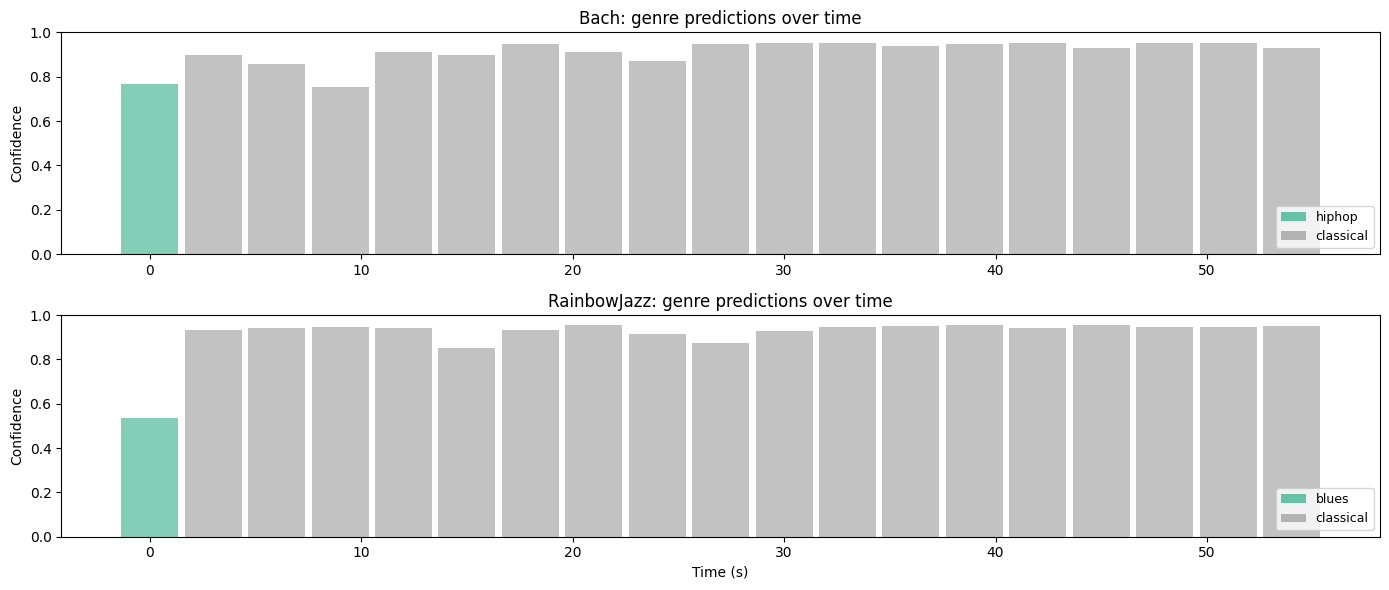

In [12]:
# Visual comparison: top prediction confidence over time
fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=False)

for ax, (name, clip) in zip(axes, [("Bach", bach), ("RainbowJazz", jazz)]):
    window = 5  # seconds
    hop = 3
    max_len = min(len(clip), SR * 60)  # limit to 60s
    clip_used = clip[:max_len]

    times, labels, scores = [], [], []
    for start in range(0, max_len - SR * window, SR * hop):
        segment = clip_used[start:start + SR * window]
        result = pipe_gtzan({"array": segment, "sampling_rate": SR}, top_k=1)
        times.append(start / SR)
        labels.append(result[0]["label"])
        scores.append(result[0]["score"])

    # Color by genre
    unique = list(set(labels))
    colors = plt.cm.Set2(np.linspace(0, 1, max(len(unique), 1)))
    color_map = {g: colors[i] for i, g in enumerate(unique)}
    bar_colors = [color_map[l] for l in labels]

    ax.bar(times, scores, width=hop*0.9, color=bar_colors, alpha=0.8)
    ax.set_ylim(0, 1)
    ax.set_ylabel("Confidence")
    ax.set_title(f"{name}: genre predictions over time")

    # Legend
    from matplotlib.patches import Patch
    legend_handles = [Patch(facecolor=color_map[g], label=g) for g in unique]
    ax.legend(handles=legend_handles, loc='lower right', fontsize=9)

axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

---

## Part B: Environmental Sound Classification (ESC-50)

Now we train our own classifier. ESC-50 has 2000 clips (5 seconds each) across 50 categories in 5 groups:

| Group | Examples |
|---|---|
| **Animals** | dog, rooster, pig, cow, frog, cat, hen, insects, sheep, crow |
| **Natural soundscapes** | rain, sea waves, crackling fire, crickets, chirping birds, water drops, wind, pouring water, toilet flush, thunderstorm |
| **Human (non-speech)** | crying baby, sneezing, clapping, breathing, coughing, footsteps, laughing, brushing teeth, snoring, drinking/sipping |
| **Interior/domestic** | door knock, mouse click, keyboard, door creaking, can opening, washing machine, vacuum cleaner, clock alarm, clock tick, glass breaking |
| **Exterior/urban** | helicopter, chainsaw, siren, car horn, engine, train, church bells, airplane, fireworks, hand saw |

5-second clips = fits in Colab free tier.

### B1. Load and explore

In [13]:
from datasets import load_dataset, Audio as HFAudio

esc50 = load_dataset("ashraq/esc50")
print(esc50)
print(f"\nTotal clips: {len(esc50['train'])}")
print(f"Columns: {esc50['train'].column_names}")

README.md:   0%|          | 0.00/345 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00002-2f1ab7b824ec75(…):   0%|          | 0.00/387M [00:00<?, ?B/s]

data/train-00001-of-00002-27425e5c1846b4(…):   0%|          | 0.00/387M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['filename', 'fold', 'target', 'category', 'esc10', 'src_file', 'take', 'audio'],
        num_rows: 2000
    })
})

Total clips: 2000
Columns: ['filename', 'fold', 'target', 'category', 'esc10', 'src_file', 'take', 'audio']


In [14]:
# All 50 categories
categories = sorted(set(esc50["train"]["category"]))
print(f"{len(categories)} categories:\n")
for i in range(0, len(categories), 5):
    row = categories[i:i+5]
    print("  ".join(f"{c:20s}" for c in row))

50 categories:

airplane              breathing             brushing_teeth        can_opening           car_horn            
cat                   chainsaw              chirping_birds        church_bells          clapping            
clock_alarm           clock_tick            coughing              cow                   crackling_fire      
crickets              crow                  crying_baby           dog                   door_wood_creaks    
door_wood_knock       drinking_sipping      engine                fireworks             footsteps           
frog                  glass_breaking        hand_saw              helicopter            hen                 
insects               keyboard_typing       laughing              mouse_click           pig                 
pouring_water         rain                  rooster               sea_waves             sheep               
siren                 sneezing              snoring               thunderstorm          toilet_flush        
tra

In [15]:
# Listen to sounds similar to our recordings
interesting = ["thunderstorm", "rain", "church_bells", "sea_waves", "wind"]

for cat_name in interesting:
    example = [x for x in esc50["train"] if x["category"] == cat_name][0]
    audio = example["audio"]
    print(f"\n{cat_name} ({len(audio['array'])/audio['sampling_rate']:.1f}s):")
    display(Audio(audio["array"], rate=audio["sampling_rate"]))


thunderstorm (5.0s):



rain (5.0s):



church_bells (5.0s):



sea_waves (5.0s):



wind (5.0s):


In [16]:
from collections import Counter

cat_counts = Counter(esc50["train"]["category"])
print(f"Clips per category: {min(cat_counts.values())} (perfectly balanced)")
print(f"Total: {sum(cat_counts.values())} clips across {len(cat_counts)} categories")

Clips per category: 40 (perfectly balanced)
Total: 2000 clips across 50 categories


### B2. Prepare data

ESC-50 comes with 5 predefined folds. We use folds 1 through 4 for training and fold 5 for testing.

In [17]:
from transformers import AutoFeatureExtractor

model_id = "ntu-spml/distilhubert"
feature_extractor = AutoFeatureExtractor.from_pretrained(
    model_id, do_normalize=True, return_attention_mask=True
)

# Label mappings
esc_categories = sorted(set(esc50["train"]["category"]))
esc_label2id = {cat: i for i, cat in enumerate(esc_categories)}
esc_id2label = {i: cat for i, cat in enumerate(esc_categories)}

def add_label(example):
    example["label"] = esc_label2id[example["category"]]
    return example

esc50_labeled = esc50["train"].map(add_label)

# Split by fold
esc_train = esc50_labeled.filter(lambda x: x["fold"] != 5)
esc_test = esc50_labeled.filter(lambda x: x["fold"] == 5)

print(f"Train: {len(esc_train)} clips (folds 1 to 4)")
print(f"Test:  {len(esc_test)} clips (fold 5)")

preprocessor_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Train: 1600 clips (folds 1 to 4)
Test:  400 clips (fold 5)


In [18]:
# Resample to 16kHz
esc_train = esc_train.cast_column("audio", HFAudio(sampling_rate=16000))
esc_test = esc_test.cast_column("audio", HFAudio(sampling_rate=16000))

# Preprocess
max_duration_esc = 5.0

def preprocess_esc(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration_esc),
        truncation=True,
        return_attention_mask=True,
    )
    return inputs

# Remove all columns except label
cols_to_remove = [c for c in esc_train.column_names if c != "label"]

esc_train_encoded = esc_train.map(
    preprocess_esc,
    remove_columns=cols_to_remove,
    batched=True,
    batch_size=50,
    writer_batch_size=50,
    num_proc=1,
)

esc_test_encoded = esc_test.map(
    preprocess_esc,
    remove_columns=cols_to_remove,
    batched=True,
    batch_size=50,
    writer_batch_size=50,
    num_proc=1,
)

print(f"Train: {esc_train_encoded}")
print(f"Test:  {esc_test_encoded}")

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Train: Dataset({
    features: ['label', 'input_values', 'attention_mask'],
    num_rows: 1600
})
Test:  Dataset({
    features: ['label', 'input_values', 'attention_mask'],
    num_rows: 400
})


In [19]:
# Verify
sample = esc_train_encoded[0]
print(f"Input: {len(sample['input_values'])} samples ({len(sample['input_values'])/16000:.1f}s)")
print(f"Mean:  {np.mean(sample['input_values']):.8f} (should be ~0)")
print(f"Var:   {np.var(sample['input_values']):.4f} (should be ~1)")
print(f"Label: {sample['label']} = {esc_id2label[sample['label']]}")

Input: 80000 samples (5.0s)
Mean:  0.00000000 (should be ~0)
Var:   0.9999 (should be ~1)
Label: 18 = dog


### B3. Fine-tune DistilHuBERT on ESC-50

Same model, same recipe as GTZAN. Only the dataset and number of labels change.

In [20]:
from transformers import AutoModelForAudioClassification

model_esc = AutoModelForAudioClassification.from_pretrained(
    model_id,
    num_labels=len(esc_categories),
    label2id={v: str(k) for k, v in esc_id2label.items()},
    id2label={str(k): v for k, v in esc_id2label.items()},
)

print(f"Base model: {model_id}")
print(f"Classes:    {len(esc_categories)}")
print(f"Parameters: {sum(p.numel() for p in model_esc.parameters())/1e6:.1f}M")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/94.0M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/49 [00:00<?, ?it/s]

HubertForSequenceClassification LOAD REPORT from: ntu-spml/distilhubert
Key               | Status  | 
------------------+---------+-
projector.bias    | MISSING | 
classifier.bias   | MISSING | 
classifier.weight | MISSING | 
projector.weight  | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Base model: ntu-spml/distilhubert
Classes:    50
Parameters: 23.7M


In [21]:
import evaluate
from transformers import TrainingArguments, Trainer

accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=eval_pred.label_ids)

training_args = TrainingArguments(
    output_dir="distilhubert-finetuned-esc50",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,  # it was 8
    per_device_eval_batch_size=16,
    num_train_epochs=5,              # it was 15
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    push_to_hub=False,
    report_to="none",
)

trainer = Trainer(
    model=model_esc,
    args=training_args,
    train_dataset=esc_train_encoded,
    eval_dataset=esc_test_encoded,
    processing_class=feature_extractor,
    compute_metrics=compute_metrics,
)

print("Starting ESC-50 training...")
trainer.train()

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Starting ESC-50 training...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

TrainOutput(global_step=500, training_loss=3.143615699768066, metrics={'train_runtime': 32646.7753, 'train_samples_per_second': 0.245, 'train_steps_per_second': 0.015, 'total_flos': 9.101445888e+16, 'train_loss': 3.143615699768066, 'epoch': 5.0})

In [22]:
import os
os.listdir("distilhubert-finetuned-esc50")

['checkpoint-200',
 'checkpoint-100',
 'checkpoint-400',
 'checkpoint-500',
 'checkpoint-300']

In [23]:
from huggingface_hub import notebook_login
notebook_login()

trainer.model.push_to_hub("sonicase/distilhubert-finetuned-esc50")
feature_extractor.push_to_hub("sonicase/distilhubert-finetuned-esc50")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...uhp9lzt/model.safetensors:   1%|          |  553kB / 94.8MB            

README.md: 0.00B [00:00, ?B/s]

CommitInfo(commit_url='https://huggingface.co/sonicase/distilhubert-finetuned-esc50/commit/cbc3eed37256728313a0653d836bacba5b35e40c', commit_message='Upload feature extractor', commit_description='', oid='cbc3eed37256728313a0653d836bacba5b35e40c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/sonicase/distilhubert-finetuned-esc50', endpoint='https://huggingface.co', repo_type='model', repo_id='sonicase/distilhubert-finetuned-esc50'), pr_revision=None, pr_num=None)

### B4. Evaluate

In [24]:
results = trainer.evaluate()
print(f"ESC-50 Results:")
print(f"  Loss:     {results['eval_loss']:.4f}")
print(f"  Accuracy: {results['eval_accuracy']:.2%}")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


ESC-50 Results:
  Loss:     2.7580
  Accuracy: 46.75%


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


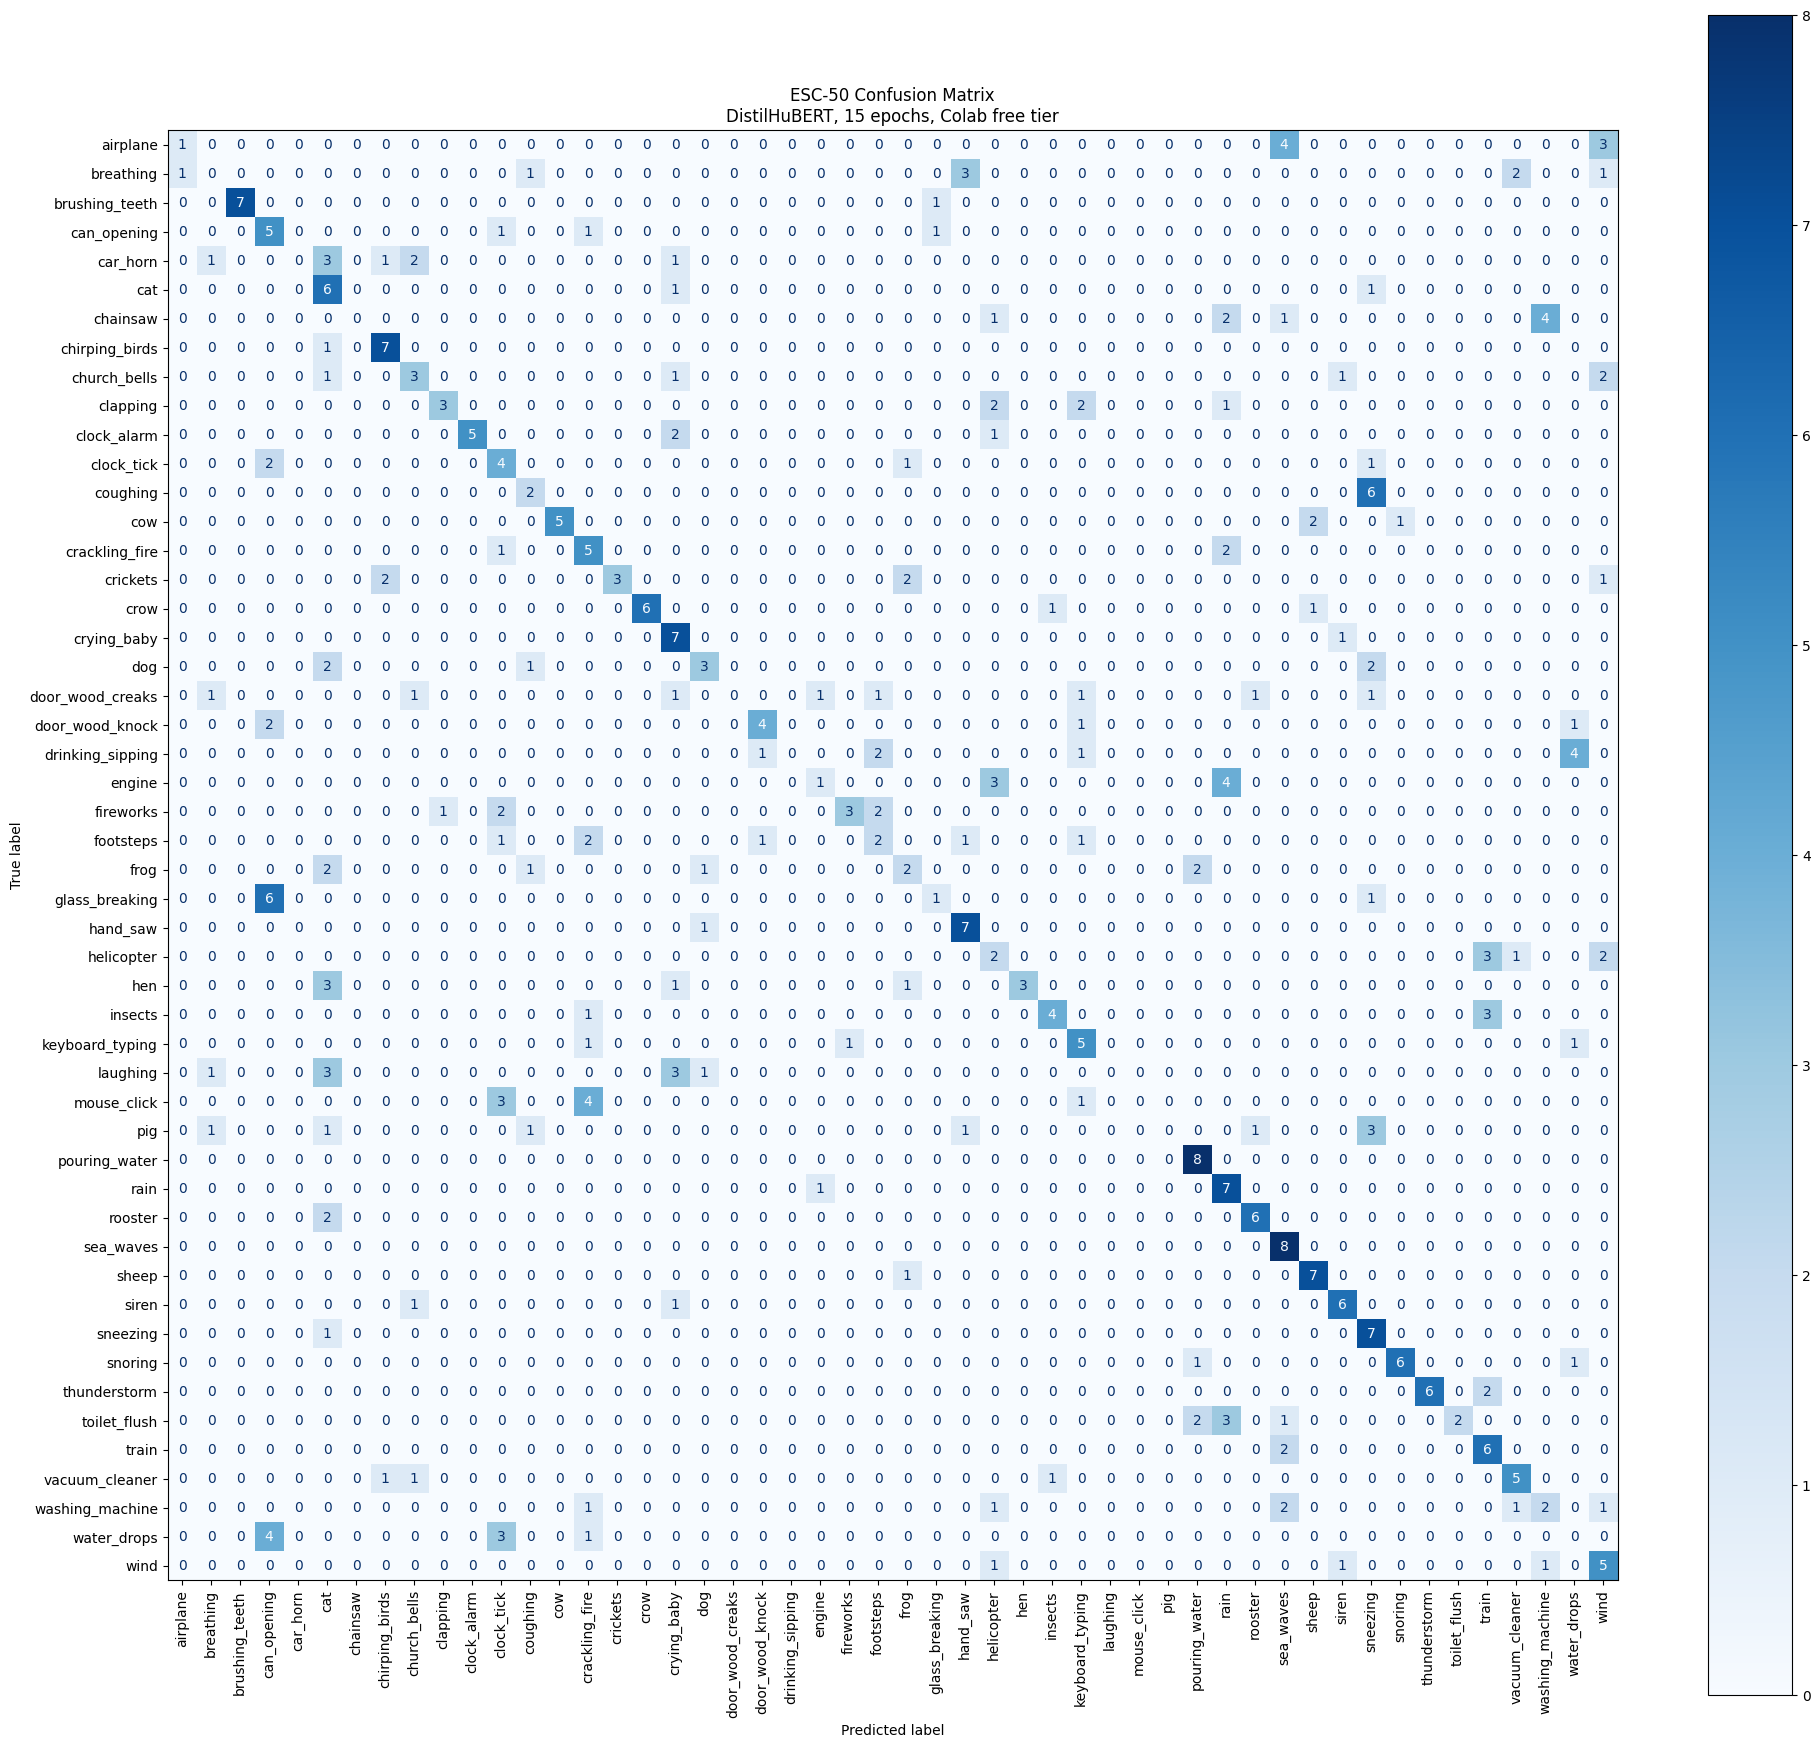

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds = trainer.predict(esc_test_encoded)
y_pred = np.argmax(preds.predictions, axis=1)
y_true = preds.label_ids

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(20, 18))
disp = ConfusionMatrixDisplay(cm, display_labels=esc_categories)
disp.plot(ax=ax, cmap='Blues', xticks_rotation=90, values_format='d')
ax.set_title("ESC-50 Confusion Matrix\nDistilHuBERT, 15 epochs, Colab free tier")
plt.tight_layout()
plt.show()

In [26]:
# Best and worst categories
per_class_acc = {}
for i, cat in enumerate(esc_categories):
    mask = y_true == i
    if mask.sum() > 0:
        per_class_acc[cat] = (y_pred[mask] == i).mean()

sorted_acc = sorted(per_class_acc.items(), key=lambda x: x[1], reverse=True)

print("Easiest (top 10):")
for cat, acc in sorted_acc[:10]:
    print(f"  {cat:25s} {acc:.0%}")

print(f"\nHardest (bottom 10):")
for cat, acc in sorted_acc[-10:]:
    print(f"  {cat:25s} {acc:.0%}")

Easiest (top 10):
  pouring_water             100%
  sea_waves                 100%
  brushing_teeth            88%
  chirping_birds            88%
  crying_baby               88%
  hand_saw                  88%
  rain                      88%
  sheep                     88%
  sneezing                  88%
  cat                       75%

Hardest (bottom 10):
  glass_breaking            12%
  breathing                 0%
  car_horn                  0%
  chainsaw                  0%
  door_wood_creaks          0%
  drinking_sipping          0%
  laughing                  0%
  mouse_click               0%
  pig                       0%
  water_drops               0%


---

## Part C: Test on Our Soundscape Recordings

The real test: does our ESC-50 model recognize thunder and chimes from our own field recordings?

In [29]:
# Fix id2label keys
trainer.model.config.id2label = {int(k): v for k, v in trainer.model.config.id2label.items()}
trainer.model.config.label2id = {v: int(k) for k, v in trainer.model.config.id2label.items()}

In [30]:
pipe_esc = pipeline(
    "audio-classification",
    model=trainer.model,
    feature_extractor=feature_extractor,
    device=0 if torch.cuda.is_available() else -1,
)

In [31]:
print("=" * 60)
print("OUR RECORDINGS vs ESC-50 CLASSIFIER")
print("=" * 60)

thunder_5s = thunder[:SR * 5]
chimes_5s = chimes[:SR * 5]

print("\nThunder (Ubud, Bali):")
display(Audio(thunder_5s, rate=SR))
show_predictions(pipe_esc({"array": thunder_5s, "sampling_rate": SR}, top_k=5), "Thunder")

print("\nChimes (Georgia):")
display(Audio(chimes_5s, rate=SR))
show_predictions(pipe_esc({"array": chimes_5s, "sampling_rate": SR}, top_k=5), "Chimes")

OUR RECORDINGS vs ESC-50 CLASSIFIER

Thunder (Ubud, Bali):



Thunder:
  sea_waves       7.5% ██
  washing_machine 6.7% ██
  train           6.7% █
  thunderstorm    6.3% █
  helicopter      6.1% █

Chimes (Georgia):



Chimes:
  sneezing        8.5% ██
  cat             7.4% ██
  rooster         7.3% ██
  coughing        6.8% ██
  clock_alarm     4.3% █


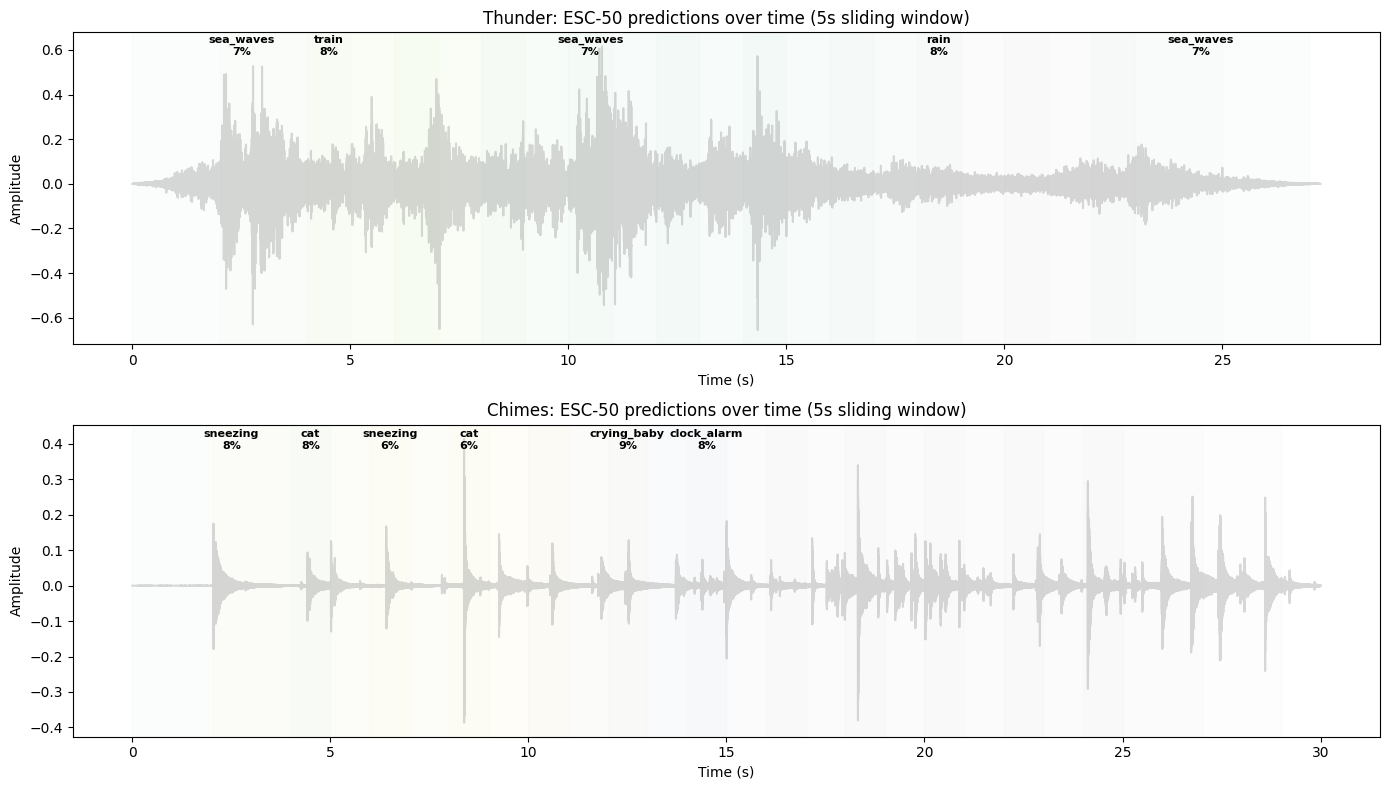

In [32]:
# Sliding window: how predictions change across the full recording
window_sec = 5
hop_sec = 2

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

for ax, (clip_name, clip_full) in zip(axes, [("Thunder", thunder), ("Chimes", chimes)]):
    max_len = min(len(clip_full), SR * 30)
    clip_used = clip_full[:max_len]

    times, top_labels, top_scores = [], [], []
    for start in range(0, max_len - SR * window_sec, SR * hop_sec):
        segment = clip_used[start:start + SR * window_sec]
        result = pipe_esc({"array": segment, "sampling_rate": SR}, top_k=1)
        times.append(start / SR)
        top_labels.append(result[0]["label"])
        top_scores.append(result[0]["score"])

    # Waveform
    t = np.arange(len(clip_used)) / SR
    ax.plot(t, clip_used, alpha=0.3, color='gray')

    # Prediction overlay
    unique_labels = list(set(top_labels))
    colors = plt.cm.Set2(np.linspace(0, 1, max(len(unique_labels), 1)))
    label_color = {label: colors[i] for i, label in enumerate(unique_labels)}

    for i, (time_s, label, score) in enumerate(zip(times, top_labels, top_scores)):
        ax.axvspan(time_s, time_s + window_sec, alpha=score * 0.3, color=label_color[label])
        if i == 0 or label != top_labels[i-1]:
            ax.text(time_s + window_sec/2, ax.get_ylim()[1] * 0.85,
                    f"{label}\n{score:.0%}", ha='center', fontsize=8, fontweight='bold')

    ax.set_title(f"{clip_name}: ESC-50 predictions over time ({window_sec}s sliding window)")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")

plt.tight_layout()
plt.show()

The sliding window reveals how different parts of the recording get classified differently. Thunder with rain in the background might flip between "thunderstorm" and "rain". Chimes might register as "church_bells" during hits and something else during silence.

---

## Summary

| | GTZAN (Music) | ESC-50 (Environment) |
|---|---|---|
| **Task** | Genre classification | Sound classification |
| **Classes** | 10 genres | 50 categories |
| **Data** | 999 songs, 30s each | 2000 clips, 5s each |
| **Base model** | DistilHuBERT | DistilHuBERT |
| **Tested on** | Bach, RainbowJazz | Thunder, Chimes |

Same model, same pipeline, different data, different behavior. The genre model hears music everywhere. The ESC-50 model hears rain, bells, and thunder.

**Training data defines the model.** The architecture is just the vessel.

### What we learned

- **Transfer learning works**: a speech model adapts to music genres and environmental sounds
- **50 classes is harder than 10**: more categories, fewer examples per class, more acoustic overlap
- **The right data matters most**: same 23M parameter model, completely different capabilities
- **Sliding window** shows how predictions change as the acoustic content evolves

### Next: Chapter 5

Automatic Speech Recognition with CTC and Seq2Seq.

---

📖 **Course**: [HF Audio Course, Unit 4](https://huggingface.co/learn/audio-course/en/chapter4/introduction)